# Телеком: исследование оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Исследовательский анализ данных

#### Импорт библиотек

In [ ]:
!pip install sweetviz -q
!pip install keras

In [ ]:
!pip install scikeras --user

In [ ]:
!pip install tensorflow --user

In [ ]:
!pip install optuna
!pip install catboost

In [6]:
#import sweetviz as sv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [9]:
import time
from numpy.random import RandomState
from tqdm import notebook
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import re
from matplotlib import cm

In [10]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn')

#### Чтение датасетов

In [11]:
try:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv', index_col=['customerID'],
                          parse_dates=['BeginDate', 'EndDate'])
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')
except:
    contract_df = pd.read_csv('F:/final_provider/final_provider/contract.csv', index_col=['customerID'],
                          parse_dates=['BeginDate', 'EndDate'])
    personal_df = pd.read_csv('F:/final_provider/final_provider/personal.csv', index_col='customerID')
    internet_df = pd.read_csv('F:/final_provider/final_provider/internet.csv', index_col='customerID')
    phone_df = pd.read_csv('F:/final_provider/final_provider/phone.csv', index_col='customerID')

#### Получение первичной информации о данных

In [12]:
for i in [contract_df, personal_df, internet_df, phone_df]:
    display(i.head())
    display(i.info())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


None

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

#### Добавление колонки Churn, отражающей факт ухода клиента

In [13]:
churn_df = pd.DataFrame({'Churn': (contract_df.EndDate != 'No').astype(int)})
churn_df.head()

,Churn
customerID,
7590-VHVEG,0
5575-GNVDE,0
3668-QPYBK,1
7795-CFOCW,0
9237-HQITU,1


In [14]:
data = contract_df.join(churn_df)
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Получение инсайтов

Распределение величин ежемесячных платежей (MonthlyCharges) всех и ушедших клиентов

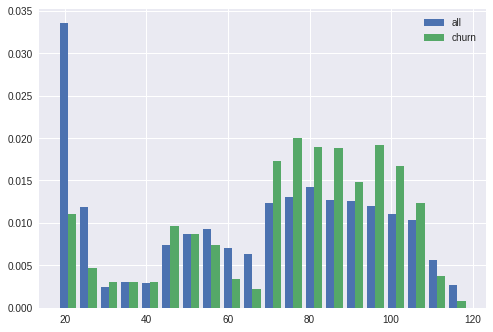

In [15]:
plt.style.use('seaborn')
plt.hist([data.MonthlyCharges, data[data.Churn == 1].MonthlyCharges], label=['all', 'churn'], 
         bins=20, density=True)
plt.legend(loc='best')
plt.show()

In [16]:
data.MonthlyCharges.describe(), data[data.Churn == 1].MonthlyCharges.describe()

(count    7043.000000
 mean       64.761692
 std        30.090047
 min        18.250000
 25%        35.500000
 50%        70.350000
 75%        89.850000
 max       118.750000
 Name: MonthlyCharges, dtype: float64,
 count    1869.000000
 mean       74.441332
 std        24.666053
 min        18.850000
 25%        56.150000
 50%        79.650000
 75%        94.200000
 max       118.350000
 Name: MonthlyCharges, dtype: float64)

Из двух распределений видим, что доля ушедших клиентов в дорогих тарифах гораздо выше чем в базовых. На это указывают также более высокие медиана, квартили и среднее для ушедших клиентов.

In [17]:
phone_df['Phone'] = 'Yes'
internet_df['Internet'] = 'Yes'

In [18]:
services_df = churn_df.join([phone_df['Phone'], internet_df['Internet']])
services_df = services_df.fillna('No')
services_df.head()

,Churn,Phone,Internet
customerID,,,
7590-VHVEG,0,No,Yes
5575-GNVDE,0,Yes,Yes
3668-QPYBK,1,Yes,Yes
7795-CFOCW,0,No,Yes
9237-HQITU,1,Yes,Yes


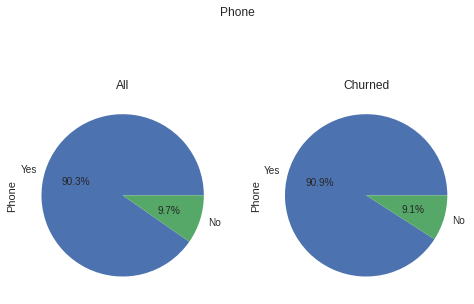

In [19]:
plt.suptitle('Phone')
plt.subplot(1, 2, 1)
services_df.Phone.value_counts().plot(kind='pie', title='All', autopct='%1.1f%%')
plt.subplot(1, 2, 2)
services_df[services_df.Churn == 1].Phone.value_counts().plot(kind='pie', ax=plt.gca(), title='Churned', autopct='%1.1f%%')
plt.show()

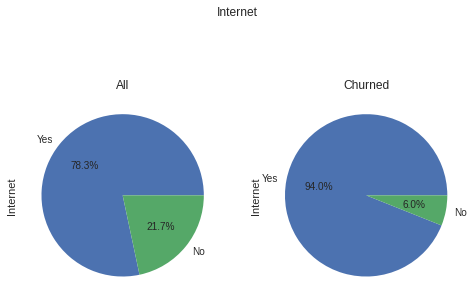

In [20]:
plt.suptitle('Internet')
plt.subplot(1, 2, 1)
services_df.Internet.value_counts().plot(kind='pie', title='All', autopct='%1.1f%%')
plt.subplot(1, 2, 2)
services_df[services_df.Churn == 1].Internet.value_counts().plot(kind='pie', ax=plt.gca(), title='Churned', autopct='%1.1f%%')
plt.show()

Доля не пользующихся интернетом клиентов среди ушедших в 3,5 раза выше относительно всех клиентов. По телефонии соотношения одинаковы.

In [21]:
data = data.join(services_df.loc[:, 'Phone':])
data = data.fillna('No')

## Предобработка

#### Работа с пропусками

In [22]:
data.iloc[488]

BeginDate                 2020-02-01 00:00:00
EndDate                                    No
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                                 
Churn                                       0
Phone                                      No
Internet                                  Yes
Name: 4472-LVYGI, dtype: object

In [23]:
data[data['TotalCharges'] == " "]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Phone,Internet
customerID,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0,No,Yes
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0,Yes,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0,Yes,Yes
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0,Yes,No
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0,No,Yes
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0,Yes,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0,Yes,No
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0,Yes,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0,Yes,No


In [24]:
data.loc[data['TotalCharges'] == " ", 'TotalCharges'] = 0
data.iloc[488]

BeginDate                 2020-02-01 00:00:00
EndDate                                    No
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                                0
Churn                                       0
Phone                                      No
Internet                                  Yes
Name: 4472-LVYGI, dtype: object

In [25]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Phone,Internet
customerID,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,Yes
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Yes,Yes
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,Yes
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes,Yes


#### Присоединение датасета с персональными данными клиентов

In [26]:
personal_df.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [27]:
data = data.join(personal_df)
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Phone,Internet,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,Yes,Female,0,Yes,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Yes,Yes,Male,0,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,Male,0,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,Yes,Male,0,No,No
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes,Yes,Female,0,No,No


#### Добавление колонки Period (срок обслуживания) по состоянию на 2020-02-01

In [28]:
data['EndDate'] = data['EndDate'].where(data['EndDate'] != 'No', '2020-02-01')

In [29]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Phone,Internet,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,Yes,Female,0,Yes,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Yes,Yes,Male,0,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,Male,0,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,Yes,Male,0,No,No
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes,Yes,Female,0,No,No


In [30]:
data['Period'] = (data['EndDate'] - data['BeginDate']).dt.days
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Phone,Internet,gender,SeniorCitizen,Partner,Dependents,Period
customerID,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,Yes,Female,0,Yes,No,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Yes,Yes,Male,0,No,No,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,Male,0,No,No,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,Yes,Male,0,No,No,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes,Yes,Female,0,No,No,61


#### Составление полного датасета

In [31]:
data = data.join([internet_df.loc[:, :'StreamingMovies'], phone_df.loc[:, :'MultipleLines']])
data = data.fillna('No')
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Phone,Internet,gender,SeniorCitizen,Partner,Dependents,Period,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,Yes,Female,0,Yes,No,31,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Yes,Yes,Male,0,No,No,1036,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,Male,0,No,No,61,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,Yes,Male,0,No,No,1371,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes,Yes,Female,0,No,No,61,Fiber optic,No,No,No,No,No,No,No


#### Переименование фичей

In [32]:
import re

data_columns_snake = []

for a in data.columns.tolist():
    b=list(a)
    [b.insert(x,'_') for x in [m.start() for m in re.finditer("[A-Z]",a)][:0:-1]]
    res = ''.join(b).lower()
    data_columns_snake.append(res)

data_columns_snake

['begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'churn',
 'phone',
 'internet',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'period',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'multiple_lines']

In [33]:
data.columns = data_columns_snake

In [34]:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,phone,internet,gender,senior_citizen,partner,dependents,period,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,Yes,Female,0,Yes,No,31,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Yes,Yes,Male,0,No,No,1036,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,Male,0,No,No,61,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,Yes,Male,0,No,No,1371,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes,Yes,Female,0,No,No,61,Fiber optic,No,No,No,No,No,No,No


#### Получение детальной информации

In [36]:
data.begin_date.describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begin_date, dtype: object

#### Получение нескольких версий датасета с разным количеством фичей

In [39]:
data_1 = data[:]
data_2 = data[:]

In [40]:
data_1 = data_1.drop(columns=['begin_date', 'end_date'])

In [41]:
data_2 = data_2.drop(columns=['begin_date', 'end_date', 'internet_service', 'online_backup', 
                              'device_protection', 'streaming_t_v', 'streaming_movies', 'multiple_lines'])

In [42]:
data_2.dtypes

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
churn                  int64
phone                 object
internet              object
gender                object
senior_citizen         int64
partner               object
dependents            object
period                 int64
online_security       object
tech_support          object
dtype: object

#### Кодирование категориальных фичей

In [43]:
encoded_data = data_2.select_dtypes(include=[object]).apply(LabelEncoder().fit_transform)
encoded_data = encoded_data.join(data_2.select_dtypes(exclude=[object]))

In [44]:
encoded_data_1 = data_1.select_dtypes(include=[object]).apply(LabelEncoder().fit_transform)
encoded_data_1 = encoded_data_1.join(data_1.select_dtypes(exclude=[object]))

In [45]:
encoded_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   int64  
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   int64  
 3   phone              7043 non-null   int64  
 4   internet           7043 non-null   int64  
 5   gender             7043 non-null   int64  
 6   partner            7043 non-null   int64  
 7   dependents         7043 non-null   int64  
 8   internet_service   7043 non-null   int64  
 9   online_security    7043 non-null   int64  
 10  online_backup      7043 non-null   int64  
 11  device_protection  7043 non-null   int64  
 12  tech_support       7043 non-null   int64  
 13  streaming_t_v      7043 non-null   int64  
 14  streaming_movies   7043 non-null   int64  
 15  multiple_lines     7043 non-null   int64  
 16  monthly_charge

In [46]:
encoded_data_1.reset_index(drop=True, inplace=True)
encoded_data_1.head()

,type,paperless_billing,payment_method,phone,internet,gender,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,monthly_charges,total_charges,churn,senior_citizen,period
0,0,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0,29.85,29.85,0,0,31
1,1,0,3,1,1,1,0,0,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,1036
2,0,1,3,1,1,1,0,0,0,1,1,0,0,0,0,0,53.85,108.15,1,0,61
3,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1371
4,0,1,2,1,1,0,0,0,1,0,0,0,0,0,0,0,70.70,151.65,1,0,61


In [49]:
state = 1235

In [50]:
model = RandomForestClassifier(random_state=state).fit(encoded_data_1.drop(columns=['churn']), 
                                                       encoded_data_1.churn)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

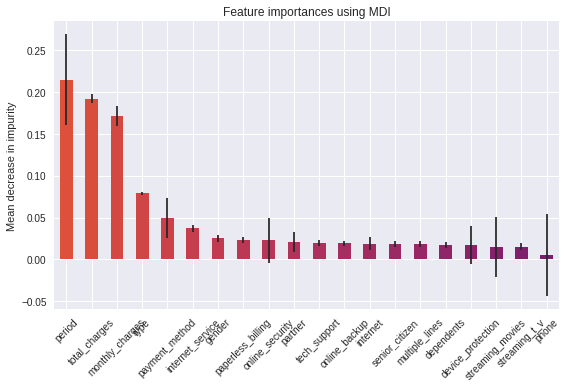

In [51]:
model_importances = pd.Series(importances, index=encoded_data_1.drop(columns=['churn']).columns)

fig, ax = plt.subplots()
color = cm.inferno_r(np.linspace(.4,.8, 30))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax, stacked=True,  color=color, rot=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
#plt.show()

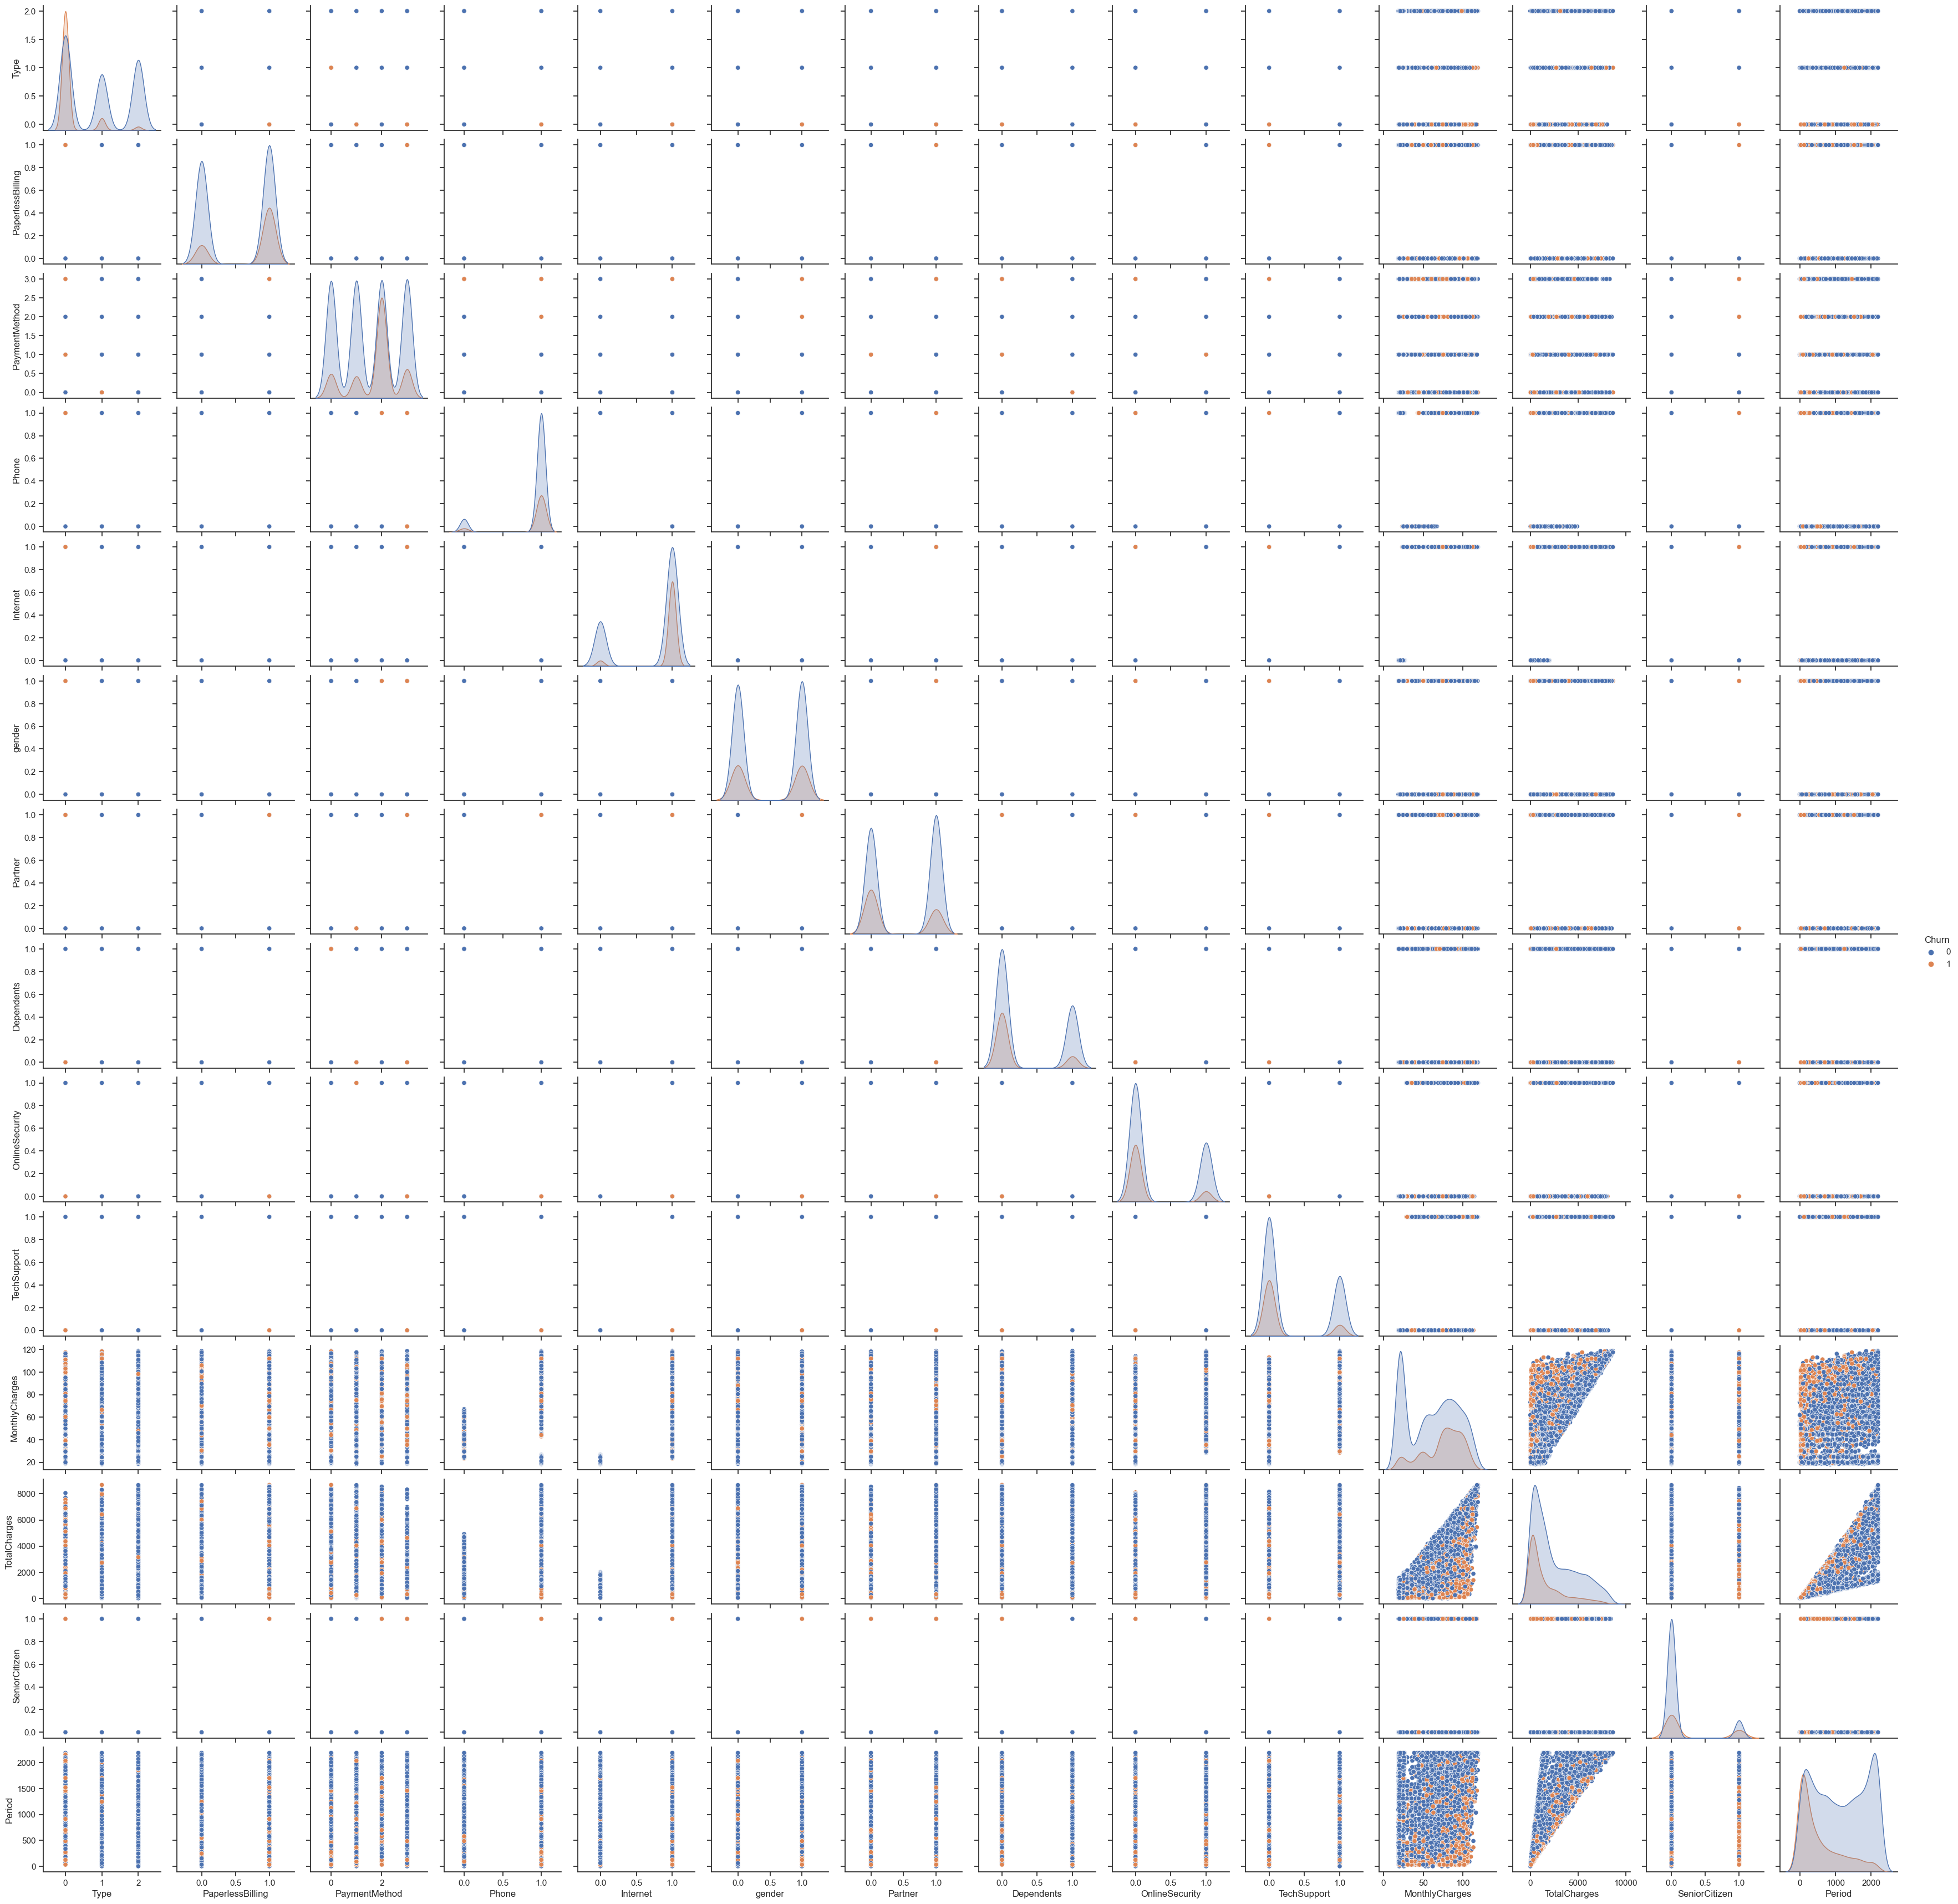

In [396]:
sns.set_theme(style='ticks')
sns.pairplot(encoded_data, hue='Churn')

report = sv.analyze([encoded_data, 'Телеком'], pairwise_analysis='on')
report.show_notebook(w='100%', h='full', scale=None, filepath=None)

In [52]:
encoded_data_2 = encoded_data[:]

In [53]:
encoded_data_2 = encoded_data_2.drop(columns=['type', 'internet', 'total_charges'])

In [54]:
encoded_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paperless_billing  7043 non-null   int64  
 1   payment_method     7043 non-null   int64  
 2   phone              7043 non-null   int64  
 3   gender             7043 non-null   int64  
 4   partner            7043 non-null   int64  
 5   dependents         7043 non-null   int64  
 6   online_security    7043 non-null   int64  
 7   tech_support       7043 non-null   int64  
 8   monthly_charges    7043 non-null   float64
 9   churn              7043 non-null   int64  
 10  senior_citizen     7043 non-null   int64  
 11  period             7043 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 715.3+ KB


In [55]:
X = encoded_data.drop(columns=['churn']).astype(float).values
Y = encoded_data['churn'].astype(float).values

In [56]:
X1 = encoded_data_1.drop(columns=['churn']).astype(float).values

In [57]:
X2 = encoded_data_2.drop(columns=['churn']).astype(float).values

In [58]:
encoded_data_1

,type,paperless_billing,payment_method,phone,internet,gender,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,monthly_charges,total_charges,churn,senior_citizen,period
0,0,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0,29.85,29.85,0,0,31
1,1,0,3,1,1,1,0,0,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,1036
2,0,1,3,1,1,1,0,0,0,1,1,0,0,0,0,0,53.85,108.15,1,0,61
3,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1371
4,0,1,2,1,1,0,0,0,1,0,0,0,0,0,0,0,70.70,151.65,1,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,3,1,1,1,1,1,0,1,0,1,1,1,1,1,84.80,1990.50,0,0,730
7039,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,103.20,7362.90,0,0,2191
7040,0,1,2,0,1,0,1,1,0,1,0,0,0,0,0,0,29.60,346.45,0,0,337
7041,0,1,3,1,1,1,1,0,1,0,0,0,0,0,0,1,74.40,306.60,1,1,123


## Обучение моделей

#### Прототипирование модели нейронной сети

In [59]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(14, input_shape=(14,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [60]:
def create_larger():
    # create model
    model = Sequential()
    model.add(Dense(20, input_shape=(20,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [61]:
def create_smaller():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(20,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [431]:
%%time

# evaluate baseline model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(model=create_baseline, epochs=30, batch_size=20, verbose=100)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 2

In [494]:
%%time

# evaluate larger model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(model=create_larger, epochs=30, batch_size=20, verbose=100)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X1, Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 2

In [497]:
%%time

# evaluate smaller model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(model=create_smaller, epochs=30, batch_size=20, verbose=100)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X1, Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 2

In [668]:
%%time

# evaluate smaller model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(model=create_baseline, epochs=50, batch_size=10, verbose=100)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/5

In [688]:
%%time
neuro = KerasClassifier(model=create_baseline, epochs=50, batch_size=10, verbose=100).fit(X_train, y_train)
y_pred = neuro.predict(X_test)
print('Accuracy на кроссвалидации:', cross_val_score(neuro, X_train, y_train, cv=cv_outer, scoring='accuracy').mean())
print('Accuracy на обучающей:', neuro.score(X_train, y_train))
print('Accuracy на тестовой:', accuracy_score(y_test, y_pred))
print('ROC AUC на тестовой:', roc_auc_score(y_test, y_pred))

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/5

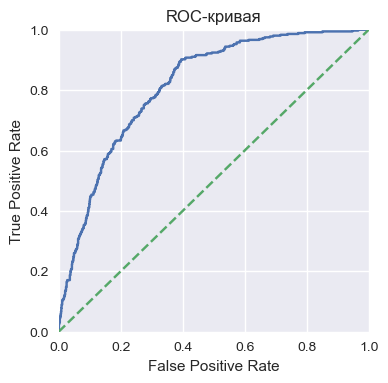

In [694]:
probabilities_X_test_neuro = neuro.predict_proba(X_test)
probabilities_one_X_test_neuro = probabilities_X_test_neuro[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_X_test_neuro) 
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [695]:
roc_auc_score(y_test, probabilities_one_X_test_neuro)

0.813729484189113

#### Подбор моделей классического ML

In [62]:
state = RandomState(12345)
kfold = StratifiedKFold(n_splits=10, shuffle=True)

In [63]:
%%time

models = [DecisionTreeClassifier(random_state=state), 
          RandomForestClassifier(random_state=state),
          CatBoostClassifier(verbose=100),
          LogisticRegression(random_state=state),
          GaussianNB(),
          LinearSVC()]

results_cross_val_1 = []

for model in notebook.tqdm(models): 
    start_time = time.time()
    pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('est', model)])  
    cv_score = cross_val_score(pipe, X, Y, cv=kfold, scoring='roc_auc').mean()    
    elapsed_time = time.time() - start_time
    results_cross_val_1.append({'model_name': model.__class__.__name__, 
                              'cv_score': '%.2f' % cv_score,
                              'learn_time': '%.2f' % elapsed_time})

  0%|          | 0/6 [00:00<?, ?it/s]

Learning rate set to 0.022666
0:	learn: 0.6772267	total: 48.8ms	remaining: 48.8s
100:	learn: 0.3847080	total: 253ms	remaining: 2.25s
200:	learn: 0.3593113	total: 495ms	remaining: 1.97s
300:	learn: 0.3417395	total: 731ms	remaining: 1.7s
400:	learn: 0.3240530	total: 988ms	remaining: 1.48s
500:	learn: 0.3064657	total: 1.28s	remaining: 1.28s
600:	learn: 0.2914701	total: 1.54s	remaining: 1.02s
700:	learn: 0.2785242	total: 1.8s	remaining: 770ms
800:	learn: 0.2676818	total: 2.03s	remaining: 505ms
900:	learn: 0.2563889	total: 2.27s	remaining: 250ms
999:	learn: 0.2467072	total: 2.54s	remaining: 0us
Learning rate set to 0.022666
0:	learn: 0.6772389	total: 3.54ms	remaining: 3.53s
100:	learn: 0.3869287	total: 252ms	remaining: 2.24s
200:	learn: 0.3590229	total: 497ms	remaining: 1.98s
300:	learn: 0.3410920	total: 774ms	remaining: 1.8s
400:	learn: 0.3226035	total: 1000ms	remaining: 1.49s
500:	learn: 0.3065365	total: 1.24s	remaining: 1.24s
600:	learn: 0.2918134	total: 1.48s	remaining: 985ms
700:	learn

In [64]:
pd.DataFrame(results_cross_val_1).sort_values('cv_score')

,model_name,cv_score,learn_time
0,DecisionTreeClassifier,0.70,0.27
4,GaussianNB,0.82,0.18
3,LogisticRegression,0.84,8.28
5,LinearSVC,0.84,3.82
1,RandomForestClassifier,0.85,5.48
2,CatBoostClassifier,0.91,37.50


In [65]:
%%time

models = [DecisionTreeClassifier(random_state=state), 
          RandomForestClassifier(random_state=state),
          CatBoostClassifier(verbose=100),
          LogisticRegression(random_state=state),
          GaussianNB(),
          LinearSVC()]

results_cross_val_2 = []

for model in notebook.tqdm(models): 
    start_time = time.time()
    pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('est', model)])  
    cv_score = cross_val_score(pipe, X1, Y, cv=kfold, scoring='roc_auc').mean()    
    elapsed_time = time.time() - start_time
    results_cross_val_2.append({'model_name': model.__class__.__name__, 
                              'cv_score': '%.2f' % cv_score,
                              'learn_time': '%.2f' % elapsed_time})

  0%|          | 0/6 [00:00<?, ?it/s]

Learning rate set to 0.022666
0:	learn: 0.6756793	total: 3.04ms	remaining: 3.03s
100:	learn: 0.3809560	total: 253ms	remaining: 2.25s
200:	learn: 0.3519567	total: 498ms	remaining: 1.98s
300:	learn: 0.3334881	total: 784ms	remaining: 1.82s
400:	learn: 0.3173980	total: 1.02s	remaining: 1.53s
500:	learn: 0.3015930	total: 1.26s	remaining: 1.26s
600:	learn: 0.2857459	total: 1.51s	remaining: 1s
700:	learn: 0.2726005	total: 1.74s	remaining: 741ms
800:	learn: 0.2602462	total: 1.98s	remaining: 491ms
900:	learn: 0.2494965	total: 2.22s	remaining: 244ms
999:	learn: 0.2406245	total: 2.48s	remaining: 0us
Learning rate set to 0.022666
0:	learn: 0.6758801	total: 2.44ms	remaining: 2.43s
100:	learn: 0.3826456	total: 276ms	remaining: 2.46s
200:	learn: 0.3540257	total: 507ms	remaining: 2.01s
300:	learn: 0.3365104	total: 743ms	remaining: 1.73s
400:	learn: 0.3204870	total: 989ms	remaining: 1.48s
500:	learn: 0.3047549	total: 1.23s	remaining: 1.23s
600:	learn: 0.2888678	total: 1.47s	remaining: 974ms
700:	learn:

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


CPU times: user 39.2 s, sys: 8.79 s, total: 48 s
Wall time: 58.6 s


In [66]:
pd.DataFrame(results_cross_val_2).sort_values('cv_score')

,model_name,cv_score,learn_time
0,DecisionTreeClassifier,0.70,0.34
4,GaussianNB,0.83,0.27
5,LinearSVC,0.84,5.22
1,RandomForestClassifier,0.85,5.72
3,LogisticRegression,0.85,8.96
2,CatBoostClassifier,0.91,38.10


Видим небольшой прирост метрики на данных с меньшим количеством коллерирующих фичей

##### Разделение датасета на выборки

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [68]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 14), (1409, 14), (5634,), (1409,))

##### Подбор гиперпараметров модели на алгоритме LinearSVC (опорных вектров)

In [558]:
%%time

import optuna
#from imblearn.combine import SMOTETomek 

def run_svc(trial):
    
    param = {
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'max_iter': trial.suggest_int('max_iter', 1000, 3000, 100),
        'dual': trial.suggest_categorical('dual', [True, False]),
        'C': trial.suggest_float('C', 1.0, 100.0),
    }

    if param["dual"] == True:
        param["penalty"] = 'l2'
        param["loss"] ='hinge'
    elif param["dual"] == False:
        param["penalty"] = 'l1'
        param["loss"] = 'squared_hinge'

    cv_outer=StratifiedKFold(n_splits=4, random_state=state, shuffle=True)
    
    pipe = Pipeline([
        ('standardize', StandardScaler()),
        #('resample', imblearn.combine.SMOTETomek(sampling_strategy=0.7, random_state=state)),
        ('est', LinearSVC(**param, random_state=state))])       
    
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring='roc_auc').mean()

Wall time: 0 ns


In [653]:
%%time

study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='Linear Support Vector Classification Optuna')
study.optimize(run_svc, n_trials=50, n_jobs=-1)

[I 2022-07-15 13:29:08,169] A new study created in memory with name: Linear Support Vector Classification Optuna
[I 2022-07-15 13:29:08,680] Trial 0 finished with value: 0.7985473609184465 and parameters: {'class_weight': None, 'max_iter': 1300, 'dual': False, 'C': 15.408330042085225}. Best is trial 0 with value: 0.7985473609184465.
[I 2022-07-15 13:29:09,196] Trial 2 finished with value: 0.80014310399058 and parameters: {'class_weight': None, 'max_iter': 1700, 'dual': False, 'C': 59.07506356150153}. Best is trial 2 with value: 0.80014310399058.
C:\Users\Майя\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2022-07-15 13:29:09,839] Trial 3 finished with value: 0.7357052269501259 and parameters: {'class_weight': 'balanced', 'max_iter': 1500, 'dual': False, 'C': 46.98403232463834}. Best is trial 2 with value: 0.80014310399058.
C:\Users\Майя\AppData\Roaming\Pyth

Wall time: 59.7 s


In [654]:
study.best_params, study.best_value

({'class_weight': None,
  'max_iter': 1900,
  'dual': False,
  'C': 67.62616723813528},
 0.8010332823891864)

In [655]:
%%time

# обучаем и тестируем модель LinearSVC

svc = LinearSVC(**study.best_params, random_state=state).fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Accuracy на кроссвалидации:', cross_val_score(svc, X_train, y_train, cv=cv_outer, scoring='accuracy').mean())
print('Accuracy на обучающей:', svc.score(X_train, y_train))
print('Accuracy на тестовой:', accuracy_score(y_test, y_pred))
print('ROC AUC на тестовой:', roc_auc_score(y_test, y_pred))

Accuracy на кроссвалидации: 0.7987221453803471
Accuracy на обучающей: 0.8028044018459354
Accuracy на тестовой: 0.7963094393186657
ROC AUC на тестовой: 0.7053711218327635
Wall time: 301 ms


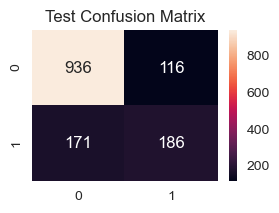

In [566]:
plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

##### Подбор гиперпараметров модели на алгоритме Logistic Regression (логистическая регрессия)

In [622]:
%%time

import optuna

def run_lr(trial):
    
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 1, 100),
#         'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 20.0),
        'C': trial.suggest_float('C', 1.0, 100.0),
    }
    
    cv_outer=StratifiedKFold(n_splits=5, random_state=state, shuffle=True)
    
    pipe = Pipeline([
        ('standardize', StandardScaler()),
        #('resample', imblearn.combine.SMOTETomek(sampling_strategy=0.7, random_state=state)),
        ('est', LogisticRegression(**param, random_state=state))])       
    
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring='roc_auc').mean()

Wall time: 0 ns


In [623]:
%%time

study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='LogisticRegression Optuna')
study.optimize(run_lr, n_trials=50, n_jobs=-1)

[I 2022-07-15 12:38:17,533] A new study created in memory with name: LogisticRegression Optuna
[I 2022-07-15 12:38:18,266] Trial 1 finished with value: 0.8035158337023898 and parameters: {'penalty': 'l2', 'solver': 'saga', 'max_iter': 95, 'C': 33.32648734525174}. Best is trial 1 with value: 0.8035158337023898.
[I 2022-07-15 12:38:18,515] Trial 0 finished with value: 0.8001404253105984 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 81, 'C': 15.309774194331697}. Best is trial 1 with value: 0.8035158337023898.
[I 2022-07-15 12:38:18,782] Trial 2 finished with value: 0.8020950321591298 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 87, 'C': 83.61843220833705}. Best is trial 1 with value: 0.8035158337023898.
[I 2022-07-15 12:38:19,483] Trial 4 finished with value: 0.8029804523554731 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 78, 'C': 97.45561028012452}. Best is trial 1 with value: 0.8035158337023898.
[I 2022-07-15 12:38:19,74

Wall time: 18.5 s


In [624]:
study.best_params, study.best_value

({'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 75, 'C': 15.28336989339327},
 0.8040515302576354)

In [650]:
study.best_params_1 = {'C': 15,
 'max_iter': 75,
 'solver': 'saga'}

In [604]:
study.best_params_2 = {'C': 50,
 'l1_ratio': 12,
 'max_iter': 5,
 'solver': 'saga'}

In [600]:
study.best_params_3 = {'C': 50,
 'l1_ratio': 15,
 'max_iter': 5,
 'penalty': 'l1',
 'solver': 'saga'}

In [651]:
%%time

# обучаем и тестируем модель LinearSVC

lr = LogisticRegression(**study.best_params_1, random_state=state).fit(X_train, y_train)
y_pred = lr.predict(X_test)
cv_outer=StratifiedKFold(n_splits=4, random_state=state, shuffle=True)
print('Accuracy на кроссвалидации:', cross_val_score(lr, X_train, y_train, cv=cv_outer, scoring='roc_auc').mean())
print('Accuracy на обучающей:', lr.score(X_train, y_train))
print('Accuracy на тестовой:', accuracy_score(y_test, y_pred))
print('ROC AUC на тестовой:', roc_auc_score(y_test, y_pred))

C:\Users\Майя\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Майя\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Майя\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Майя\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Майя\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy на кроссвалидации: 0.7790181271775598
Accuracy на обучающей: 0.7790202342917998
Accuracy на тестовой: 0.7792760823278921
ROC AUC на тестовой: 0.7013664781501954
Wall time: 1.13 s


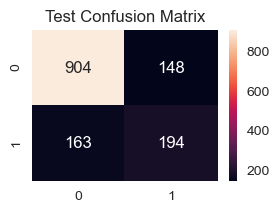

In [634]:
plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

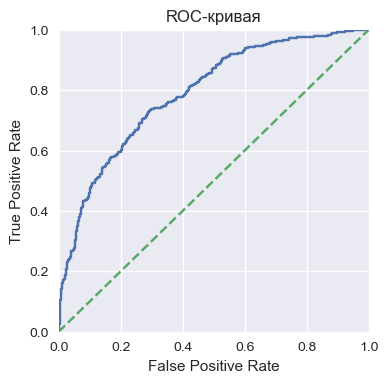

In [679]:
probabilities_X_test_lr = lr.predict_proba(X_test)
probabilities_one_X_test_lr = probabilities_X_test_lr[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_X_test_lr) 
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [692]:
roc_auc_score(y_test, probabilities_one_X_test_lr)

0.7894393498844404

###### Подбор порога классификации

In [636]:
proba_one_X_test = lr.predict_proba(X_test)[:,1]
treshold_best, accuracy_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):
    y_pred = proba_one_X_test > treshold
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > accuracy_best:
        accuracy_best = accuracy
        treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('Accuracy при подборе порога:', accuracy_best)

Оптимальный порог классификации: 0.55
Accuracy при подборе порога: 0.794889992902768


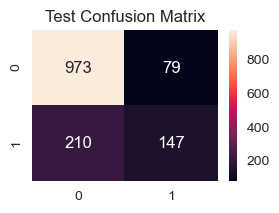

In [638]:
y_pred = proba_one_X_test > treshold_best
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

##### Подбор гиперпараметров модели на алгоритме RandomForestClassifier (случайный лес)

In [639]:
%%time

def run_rfc(trial):
    
    param = {
        'max_depth': trial.suggest_int("max_depth", 2, 50, log=True),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
    }

    cv_outer=StratifiedKFold(n_splits=4, random_state=state, shuffle=True)
    
    pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('est', RandomForestClassifier(**param, random_state=state))])       
    
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring='roc_auc').mean()

Wall time: 0 ns


In [640]:
study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='Random Forest Classifier Optuna')
study.optimize(run_rfc, n_trials=50, n_jobs=-1)

[I 2022-07-15 12:57:58,493] A new study created in memory with name: Random Forest Classifier Optuna
[I 2022-07-15 12:58:04,003] Trial 1 finished with value: 0.8467640106411024 and parameters: {'max_depth': 4, 'min_samples_leaf': 30, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8467640106411024.
[I 2022-07-15 12:58:05,027] Trial 0 finished with value: 0.8570805003164598 and parameters: {'max_depth': 18, 'min_samples_leaf': 19, 'class_weight': None}. Best is trial 0 with value: 0.8570805003164598.
[I 2022-07-15 12:58:08,613] Trial 2 finished with value: 0.8487553484653104 and parameters: {'max_depth': 4, 'min_samples_leaf': 19, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8570805003164598.
[I 2022-07-15 12:58:12,412] Trial 3 finished with value: 0.8584307260734262 and parameters: {'max_depth': 13, 'min_samples_leaf': 13, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.8584307260734262.
[I 2022-07-15 12:58:13,822] Trial 4 finished with value: 0.8452

In [641]:
study.best_params, study.best_value

({'max_depth': 25, 'min_samples_leaf': 11, 'class_weight': None},
 0.861785392544482)

In [644]:
%%time
# обучаем и тестируем модель Random Forest Classifier

rfc = RandomForestClassifier(**study.best_params, random_state=state).fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Accuracy на кроссвалидации:', cross_val_score(rfc, X_train, y_train, cv=cv_outer, scoring='accuracy').mean())
print('Accuracy на обучающей:', rfc.score(X_train, y_train))
print('Accuracy на тестовой:', accuracy_score(y_test, y_pred))
print('ROC AUC на тестовой:', roc_auc_score(y_test, y_pred))

Accuracy на кроссвалидации: 0.8214419831521389
Accuracy на обучающей: 0.8533901313454029
Accuracy на тестовой: 0.8197303051809794
ROC AUC на тестовой: 0.7173544322672034
Wall time: 5.25 s


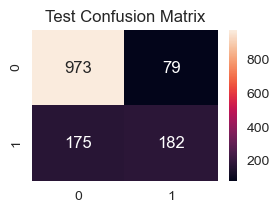

In [645]:
plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

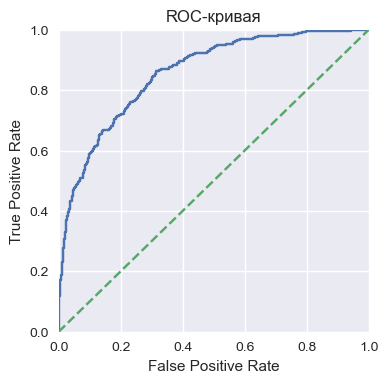

In [680]:
probabilities_X_test_rfc = rfc.predict_proba(X_test)
probabilities_one_X_test_rfc = probabilities_X_test_rfc[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_X_test_rfc) 
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [691]:
roc_auc_score(y_test, probabilities_one_X_test_rfc)

0.855973948514767

###### Подбор порога классификации

In [663]:
proba_one_X_test = rfc.predict_proba(X_test)[:,1]
treshold_best, accuracy_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):
    y_pred = proba_one_X_test > treshold
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > accuracy_best:
        accuracy_best = accuracy
        treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('Accuracy при подборе порога:', accuracy_best)

Оптимальный порог классификации: 0.54
Accuracy при подборе порога: 0.8289567068843151


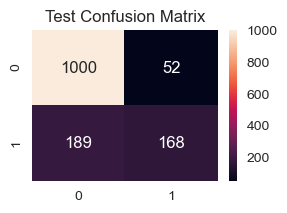

In [664]:
y_pred = proba_one_X_test > treshold_best
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

###### Обучаем и тестируем модель CatBoost с дефолтными настройками

In [70]:
%%time

cat = CatBoostClassifier(random_state=12345, 
                         # task_type='GPU'
                         )
cat.fit(pd.DataFrame(X_train), y_train, verbose=100)
y_pred = cat.predict(pd.DataFrame(X_test))
print('Accuracy на кроссвалидации:', cross_val_score(cat, X_train, y_train, cv=cv_outer, scoring='accuracy').mean())
print('Accuracy на обучающей:', cat.score(X_train, y_train))
print('Accuracy на тестовой:', accuracy_score(y_test, y_pred))
print('ROC AUC на тестовой:', roc_auc_score(y_test, y_pred))

Learning rate set to 0.021554
0:	learn: 0.6774280	total: 3.9ms	remaining: 3.9s
100:	learn: 0.3881632	total: 224ms	remaining: 1.99s
200:	learn: 0.3614975	total: 480ms	remaining: 1.91s
300:	learn: 0.3437293	total: 689ms	remaining: 1.6s
400:	learn: 0.3285366	total: 925ms	remaining: 1.38s
500:	learn: 0.3107538	total: 1.17s	remaining: 1.16s
600:	learn: 0.2966830	total: 1.42s	remaining: 944ms
700:	learn: 0.2836811	total: 1.66s	remaining: 707ms
800:	learn: 0.2709548	total: 1.88s	remaining: 466ms
900:	learn: 0.2594753	total: 2.1s	remaining: 231ms
999:	learn: 0.2488576	total: 2.35s	remaining: 0us
Learning rate set to 0.019595
0:	learn: 0.6827771	total: 1.5ms	remaining: 1.5s
1:	learn: 0.6706496	total: 3.59ms	remaining: 1.79s
2:	learn: 0.6578892	total: 6.39ms	remaining: 2.12s
3:	learn: 0.6467649	total: 9ms	remaining: 2.24s
4:	learn: 0.6348607	total: 11.8ms	remaining: 2.35s
5:	learn: 0.6241077	total: 14.5ms	remaining: 2.4s
6:	learn: 0.6148195	total: 16ms	remaining: 2.27s
7:	learn: 0.6061254	total:

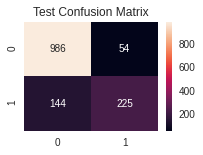

In [71]:
plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

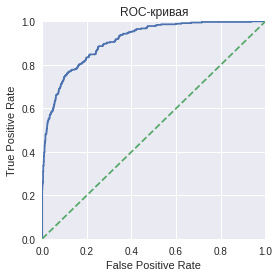

In [72]:
probabilities_X_test_cat = cat.predict_proba(X_test)
probabilities_one_X_test_cat = probabilities_X_test_cat[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_X_test_cat) 
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [73]:
roc_auc_score(y_test, probabilities_one_X_test_cat)

0.9111593183239524

###### Подбор порога классификации

In [74]:
proba_one_X_test = cat.predict_proba(X_test)[:,1]
treshold_best, accuracy_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):
    y_pred = proba_one_X_test > treshold
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > accuracy_best:
        accuracy_best = accuracy
        treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('Accuracy при подборе порога:', accuracy_best)

Оптимальный порог классификации: 0.46
Accuracy при подборе порога: 0.8637331440738112


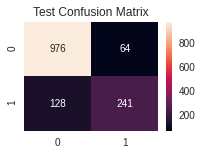

In [75]:
y_pred = proba_one_X_test > treshold_best
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

###### Сравнение результата с константной моделью классификатора

In [76]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy на обучающей:', clf.score(X_train, y_train))
print('Accuracy на тестовой:', accuracy_score(y_test, y_pred))
print('ROC AUC на тестовой:', roc_auc_score(y_test, y_pred))

Accuracy на обучающей: 0.7337593184238551
Accuracy на тестовой: 0.7381121362668559
ROC AUC на тестовой: 0.5


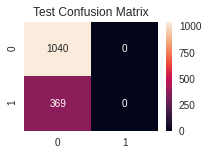

In [77]:
plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [78]:
pd.DataFrame({'model name': ['Keras Classifier', 'CatBoost Classifier', 'Linear SVC', 
                             'Logistic Regression', 'RandomForest Classifier', 'Dummy Classifier'], 
              'ROC AUC': [0.814, 0.898, 0.705, 0.789, 0.855, 0.500]}).sort_values('ROC AUC')

,model name,ROC AUC
5,Dummy Classifier,0.500
2,Linear SVC,0.705
3,Logistic Regression,0.789
0,Keras Classifier,0.814
4,RandomForest Classifier,0.855
1,CatBoost Classifier,0.898


## Выводы

1. Видим, что целевой скор удалось получить на 2 моделях: RandomForest Classifier (0.855) и CatBoost Classifier (0.898). 
2. Задачу анализа факторов, влияющих на таргет, удалось решить с помощью построения графиков features importance и pairplot
3. В решении задачи были выделены следующие ключевые шаги:
- Загрузка и предобработка данных
- Исследовательский анализ
- Проведение слияния датасетов в единый, фичеинжиниринг и выделение таргета
- Проверка фичей на мультиколлинеарность и анализ факторов, влияющих на таргет
- Подбор и обучение моделей
- Подбор гиперпараметров у выбранных моделей на обучающей выборке с помощью кроссвалидации
- Получение метрик на тестовой выборке и проверка на адекватность
- Составление вывода
4. Все шаги кроме выполнения кластеризации были выполнены. Кластеризация в данном проекте показалась избыточной. В план возможно следовало добавить выполнение однофакторных анализов